# CNN using MNIST dataset

### Loading all the dependency

In [27]:
import numpy as np 
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.examples.tutorials.mnist import input_data

### Loading data

In [41]:
train_data = pd.read_csv("../input/digit-recognizer/train.csv" , nrows=5000)
#test_data = pd.read_csv("../input/digit-recognizer/test.csv", nrows=10000)

#### Thanks a lot. **@tylerneylon**
I got the following function to read "idx" files from [**here**](https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40))

In [42]:
import struct
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

In [43]:
test_data = read_idx("../input/mytestdata/Test_data.idx3-ubyte")[:1000]
test_labels = read_idx("../input/mytestdata/Test_labels.idx1-ubyte")[:1000]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


In [44]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
labels = train_data["label"].values
labels.shape

(5000,)

### Visualizing  the data

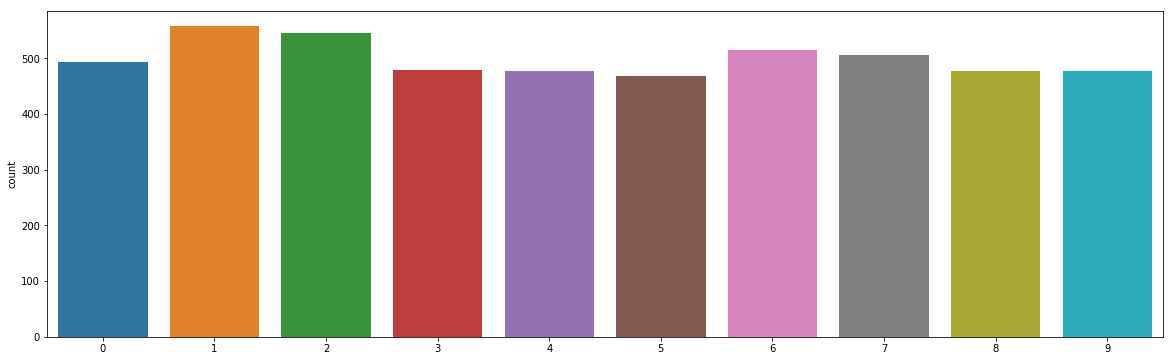

In [46]:
train_data.drop("label",axis=1, inplace=True)
plt.figure(figsize=(20,6))
sns.countplot(labels)

In [47]:
one_hot_labels = pd.get_dummies(labels)
one_hot_test_labels = pd.get_dummies(test_labels)
print("The shape of training labels :{} \n The shape of test labels {}".format(one_hot_labels.shape, one_hot_test_labels.shape))

The shape of training labels :(5000, 10) 
 The shape of test labels (1000, 10)


In [48]:
image_data = train_data.values
images = np.array([image_data[i].reshape(28,28) for i in range(image_data.shape[0])])
test_images = test_data.shape
test_data = np.array([test_data[i].reshape(-1) for i in range(test_data.shape[0])])

In [49]:
print("shape of image data {} \n shape of images {} \n shape of test data{} \n shape of test images {}"
      .format(image_data.shape , images.shape , test_data.shape , test_images))

shape of image data (5000, 784) 
 shape of images (5000, 28, 28) 
 shape of test data(1000, 784) 
 shape of test images (1000, 28, 28)


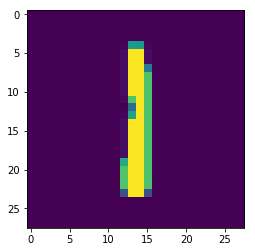

In [50]:
plt.imshow(images[2])

### Create the Model

### defining place holders

In [51]:
X = tf.placeholder(tf.float32 , shape= [None, 784], name="Images")
y = tf.placeholder(tf.float32,  shape= [None , 10], name="Labels")

### weight initialisation

In [52]:
def initialisation_weight(shape):
    init_weight = tf.truncated_normal(shape , stddev=0.1)
    return tf.Variable(init_weight)

### Bias initialisation

In [53]:
def initialisation_bias(shape):
    init_bias = tf.constant(0.1 , shape=shape)
    return tf.Variable(init_bias)

### defining convolution2d

In [54]:
def conv2d(x,W):
    return tf.nn.conv2d(x,W, strides=[1,1,1,1], padding="SAME")

### defining max pooling layer

In [55]:
def maxpool(x):
    return tf.nn.max_pool(x , ksize = [1,2,2,1] , strides=[1,2,2,1] , padding="SAME")

In [56]:
def convolutional_layer(input_x , shape):
    W= initialisation_weight(shape)
    b= initialisation_bias([shape[3]])
    
    return tf.nn.relu(conv2d(input_x , W) + b)

In [57]:
def normal_layer(input_layer , size):
    input_size = int(input_layer.get_shape()[1])
    W = initialisation_weight([input_size , size])
    b= initialisation_bias([size])
    
    return tf.matmul(input_layer , W) +b

In [58]:
x_image = tf.reshape(X,[-1,28,28,1])

### Defining CNN Model

In [59]:
convo_1 = convolutional_layer(x_image,shape=[6,6,1,32])
convo_1_pooling = maxpool(convo_1)
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = maxpool(convo_2)
convo_2_flat = tf.reshape(convo_2_pooling,[-1,7*7*64])
full_layer_one = tf.nn.relu(normal_layer(convo_2_flat,256))
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

### Output layer ( prediction layer )

In [60]:
y_pred = normal_layer(full_one_dropout,10)

### Loss fucntion and Optimizer

In [61]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy)

In [63]:
init = tf.global_variables_initializer()
steps = 500
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        
        sess.run(optimizer,feed_dict={X:image_data,y:one_hot_labels,hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%20 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            #print(sess.run(acc,feed_dict={X:test_images,y:mnist.test.labels,hold_prob:1.0}))
            #print('\n')
            print(sess.run(acc , feed_dict={X:test_data, y:one_hot_test_labels , hold_prob:1}))

Currently on step 0
Accuracy is:
0.093
Currently on step 100
Accuracy is:
0.828
Currently on step 200
Accuracy is:
0.814
Currently on step 300
Accuracy is:
0.755
Currently on step 400
Accuracy is:
0.783
Currently on step 500
Accuracy is:
0.805
Currently on step 600
Accuracy is:
0.826
Currently on step 700
Accuracy is:
0.838
Currently on step 800
Accuracy is:
0.846
Currently on step 900
Accuracy is:
0.851
Currently on step 1000
Accuracy is:
0.86
